In [30]:
import os
import json
import math
import argparse
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [31]:
parser = argparse.ArgumentParser(description='Plothole Segmentation')
parser.add_argument("--path", type=str, default=os.path.join(os.getcwd(), "data"), help="Path to the data directory")
args = parser.parse_args(args=[])

In [32]:
path = args.path
if not os.path.exists(path):
    raise ValueError(f"Path {path} does not exist")

In [33]:
imagePath = os.path.join(path, "images")

trainPath = os.path.join(imagePath, "train")
validPath = os.path.join(imagePath, "valid")

trainImagePath = os.path.join(trainPath, "images")
trainLabelsPath = os.path.join(trainPath, "labels")

In [34]:
trainImage = sorted(os.listdir(trainImagePath))
trainLabels = sorted(os.listdir(trainLabelsPath))

if len(trainImage) != len(trainLabels):
    raise ValueError(f"Number of images and labels do not match")

for i in range(len(trainImage)):
    trainImage[i] = trainImage[i][:-4]
    trainLabels[i] = trainLabels[i][:-4]

imageDF = pd.DataFrame({"imageFile": trainImage})
labelDF = pd.DataFrame({"labelFile": trainLabels})

trainDF = pd.merge(imageDF, labelDF, left_on="imageFile", right_on="labelFile", how="inner")

---

## Show segmentation mask (points) 

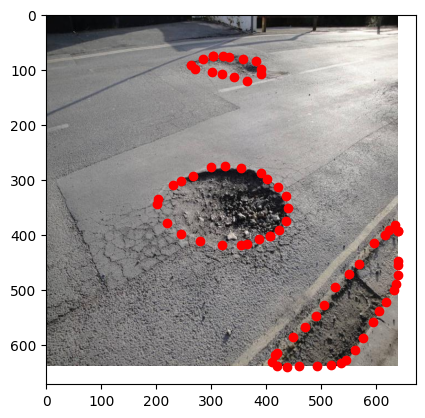

In [35]:
trainDF = trainDF.sample(frac=1).reset_index(drop=True)
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    #* 640 x 640
    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    with open(os.path.join(trainLabelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = [float(line) for line in line.strip().split(" ")[1:]]
            xs, ys = [], []
            for i in range(len(line)):
                xs.append(line[i] * xlim) if i % 2 == 0 else ys.append(line[i] * ylim)
            plt.scatter(xs, ys, color="red")
    plt.show()
    break

---

## Get bounding box from segmentation mask (points) in COCO format

In [36]:
def seg_to_bbox(seg_info):
    _, *points = seg_info.strip().split()
    points = [float(p) for p in points]
    x_min, y_min, x_max, y_max = min(points[0::2]), min(points[1::2]), max(points[0::2]), max(points[1::2])
    return [x_min, y_min, x_max - x_min, y_max - y_min]

----

## Show bounding box

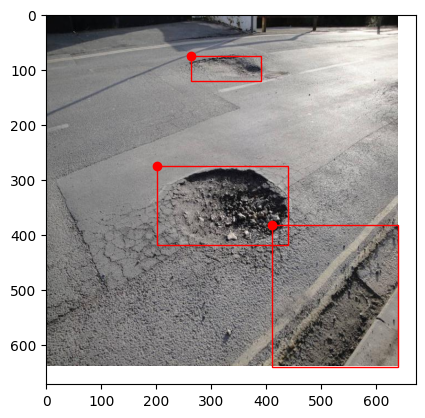

In [37]:
for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    implot = plt.imshow(image)

    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    with open(os.path.join(trainLabelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            bbox = seg_to_bbox(line)
            for i in range(len(bbox)):
                bbox[i] = bbox[i] * xlim if i % 2 == 0 else bbox[i] * ylim
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color="red")
            plt.scatter(bbox[0], bbox[1], color="red")
            plt.gca().add_patch(rect)
    plt.show()
    break

----

## Create COCO format label files

In [44]:
cocoTrainPath = os.path.join(trainPath, "cocoLabels.json")
coco = {"image": [], "annotation": [], "categories": [{"supercategory": "pothole", "id": 0, "name": "pothole"}]}


for _, row in trainDF.iterrows():
    image = cv.imread(os.path.join(trainImagePath, row["imageFile"] + ".jpg"))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    xlim = math.ceil(image.shape[1])
    ylim = math.ceil(image.shape[0])

    coco["image"].append({
        "id": row["imageFile"],
        "width": xlim,
        "height": ylim,
        "file_name": row["imageFile"] + ".jpg"
    })

    with open(os.path.join(trainLabelsPath, row["labelFile"] + ".txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            bbox = seg_to_bbox(line)
            for i in range(len(bbox)):
                bbox[i] = bbox[i] * xlim if i % 2 == 0 else bbox[i] * ylim

            seg = [float(p) for p in line.strip().split(" ")[1:]]
            seg = [p * xlim if i % 2 == 0 else p * ylim for i, p in enumerate(seg)]

            coco["annotation"].append({
                "image_id": row["imageFile"],
                "bbox": bbox,
                "category_id": 0,
                "segmentation": seg,
            })
coco

{'image': [{'id': 'pic-126-_jpg.rf.4d5c28bfd2ec83debd1fa97e86bbddb4',
   'width': 640,
   'height': 640,
   'file_name': 'pic-126-_jpg.rf.4d5c28bfd2ec83debd1fa97e86bbddb4.jpg'},
  {'id': 'pic-238-_jpg.rf.43a237ef9bd9dd28d4f798a87853f1fa',
   'width': 640,
   'height': 640,
   'file_name': 'pic-238-_jpg.rf.43a237ef9bd9dd28d4f798a87853f1fa.jpg'},
  {'id': 'pic-26-_jpg.rf.9be8ea96b8bb643747babec0e006e3a8',
   'width': 640,
   'height': 640,
   'file_name': 'pic-26-_jpg.rf.9be8ea96b8bb643747babec0e006e3a8.jpg'},
  {'id': 'pic-38-_jpg.rf.dba8be87e1cad6fbbc6f68728f95a85d',
   'width': 640,
   'height': 640,
   'file_name': 'pic-38-_jpg.rf.dba8be87e1cad6fbbc6f68728f95a85d.jpg'},
  {'id': 'pic-282-_jpg.rf.0dbe6d0d6778748a85926379c5f2e9e2',
   'width': 640,
   'height': 640,
   'file_name': 'pic-282-_jpg.rf.0dbe6d0d6778748a85926379c5f2e9e2.jpg'},
  {'id': 'pic-136-_jpg.rf.28112df3106c2b4485053cd6371a47ef',
   'width': 640,
   'height': 640,
   'file_name': 'pic-136-_jpg.rf.28112df3106c2b4485053

In [45]:
with open(cocoTrainPath, "w") as f:
    json.dump(coco, f)